In [43]:
!pip install coverage
!pip install emoji
!pip install pytest pytest-cov

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.6/343.6 KB 3.3 MB/s eta 0:00:003.3 MB/s eta 0:00:01


#Test Fuzzer

In [60]:
import random
import string
import coverage
from collections import defaultdict
import tempfile
import os
import subprocess
import unicodedata
import inspect
import heapq
import importlib
import sys
import json

In [75]:
import random

class SemiPriorityQueue:
    def __init__(self):
        self.queue = []
    
    def push(self, item, score):
        """Add an item with a given score."""
        self.queue.append((score, item))
    
    def pop(self):
        """Remove and return an item, favoring higher scores probabilistically."""
        if not self.queue:
            raise IndexError("pop from an empty priority queue")
        
        scores, items = zip(*self.queue)  # Separate scores and items
        selected = random.choices(self.queue, weights=scores, k=1)[0]  # Weighted random choice
        self.queue.remove(selected)  # Remove selected item
        return selected[1]  # Return only the item
    
    def peek(self):
        """Return an item that is more likely to be popped next (does not remove it)."""
        if not self.queue:
            return None
        scores, items = zip(*self.queue)
        selected = random.choices(items, weights=scores, k=1)[0]
        return selected
    
    def is_empty(self):
        """Check if the queue is empty."""
        return len(self.queue) == 0
    
    def size(self):
        """Return the number of elements in the queue."""
        return len(self.queue)
    
    def __str__(self):
        """Return a string representation of the queue."""
        return str(sorted(self.queue, reverse=True))  # Sort by score for visualization


# Smart Fuzzer

class SmartFuzzer:
    def __init__(self, initial_seed, trial=1000, alphabet=None):
        self.max_iterations = trial
        self.coverage_data = defaultdict(int)

        if alphabet is not None:
            self.alphabet = alphabet
        elif type(initial_seed) == type(1):
            self.alphabet = self.generate_integer_alphabet()
        elif type(initial_seed) == type(1.0):
            self.alphabet = self.generate_double_alphabet()
        else:
            self.alphabet = self.generate_alphabet()
        
        self.alphabet_length = len(self.alphabet)
        self.initial_seed = initial_seed

    def generate_alphabet(self):
        """
        This method creates alphabet with english and special characters
        Parameters:
        None
        Returns:
        str: alphabet
        """
        # English Alphabet
        english = string.ascii_letters + string.digits + string.punctuation
        print(english, "\n\n")

        # Special Characters (common punctuation and symbols)
        special_chars = string.punctuation + ''.join(chr(i) for i in range(0x2000, 0x206F))  # Additional special characters
        print(special_chars, "\n\n")

        # Combine all characters into one string
        combined_characters = english + special_chars

        # Remove duplicates while preserving order
        seen = set()
        unique_characters = []
        for char in combined_characters:
            if char not in seen:
                unique_characters.append(char)
                seen.add(char)

        # Return the result as a string
        return ''.join(unique_characters)

    def generate_double_alphabet():
        return string.digits + '.' + 'e' + "-"

    def generate_integer_alphabet():
        return string.digits + "-"
    
    def delete_char(self, inp):
        input_list = list(str(inp))
        if len(input_list) >= 1:
            index = random.sample(range(0, len(input_list)), 1)
            del input_list[index[0]]
            return input_list
        else:
            return self.replace_char(inp)
        
    def insert_char(self, inp):
        input_list = list(str(inp))
        if len(input_list) == 0:
            index = [0]
        else:
            index = random.sample(range(0, len(input_list)), 1)
        input_list.insert(index[0], random.choice(list(self.alphabet)))
        return input_list
    
    def reverse(self, inp):
        input_list = list(str(inp))
        input_list = input_list[::-1]
        return input_list
    
    def append_char(self, inp):
        input_list = list(str(inp))
        input_list.append(random.choice(list(self.alphabet)))
        return input_list
    
    def replace_char(self, inp):
        input_list = list(str(inp))
        if len(input_list) >= 1:
            replace_trial = 10
            while(replace_trial > 0):
                index = random.sample(range(0, len(input_list)), 1)
                in_place_digit = input_list[index[0]]
                replaced_digit = random.choice(list(self.alphabet))
                if in_place_digit != replaced_digit:
                    break
                else:
                    replace_trial -= 1

            input_list[index[0]] = replaced_digit
            return input_list
        else:
            return self.append_char(inp)
        
    def flip_2_char(self, inp):
        input_list = list(str(inp))
        if len(input_list) >= 2:
            flip_trial = 10
            while(flip_trial > 0):
                random_integers = random.sample(range(0, len(input_list)), 2)
                index1 = random_integers[0]
                number_at_index1 = input_list[index1]
                index2 = random_integers[1]
                number_at_index2 = input_list[index2]
                if number_at_index1 != number_at_index2:
                    break
                else:
                    flip_trial -= 1
            
            input_list[index1] = number_at_index2
            input_list[index2] = number_at_index1

            return input_list
        else:
            return self.replace_char(inp)
        
    def mutate_inp(self, inp):
        """
        Provides a mutated version of an input
        Parameters:
        inp: input
        Returns:
        mutated input
        """
        mutation_type = random.choice(["flip", "replace", "append", "delete", "insert", "reverse"])
        input_list = list(str(inp))
        print(f"mutation type selected: {mutation_type}")
        
        if mutation_type == "flip":
            input_list = self.flip_2_char(inp)
        elif mutation_type == "replace" and input_list:
            input_list = self.replace_char(inp)
        elif mutation_type == "append":
            input_list = self.append_char(inp)
        elif mutation_type == "delete" and input_list:
            input_list = self.delete_char(inp)
        elif mutation_type == "insert":
            input_list = self.insert_char(inp)
        elif mutation_type == "reverse":
            input_list = self.reverse(inp)

        mutated_inp = "".join(input_list)

        return mutated_inp
    
    def mutate(self, inp):
        while(True):
            mutated_inp = self.mutate_inp(inp)
            if type(inp) == type(""):
                return mutated_inp
            elif type(inp) == type(1):
                mutation_trial = 10
                while(mutation_trial > 0):
                    try:
                        mutated_inp = int(mutated_inp)
                        return int(mutated_inp)
                    except:
                        mutation_trial -= 1
                return None
            elif type(inp) == type(1.0):
                mutation_trial = 10
                while(mutation_trial > 0):
                    try:
                        mutated_inp = float(mutated_inp)
                        return float(mutated_inp)
                    except:
                        mutation_trial -= 1
                return None

In [ ]:
def get_function_source(func):
    """
    Returns the source code of a given function as a string.
    Parameters: 
    func (function): The function whose source code needs to be retrieved.
    Returns: 
    str: A string containing the source code of the func.
    """
    return inspect.getsource(func)

In [54]:
%%file example_function1.py

# Example usage
def sample_function(input_str):
    if "bug" in input_str:
        print("Found a bug!")
    elif "bun" in input_str:
        print("BUN")
    elif "bus" in input_str:
        print("BUS")
    elif "but" in input_str:
        print("BUT")
    elif "buz" in input_str:
        print("BUZ")
    elif "buga" in input_str:
        print("BUGA")
    elif "bugs" in input_str:
        print("BUGS")
    elif "buge" in input_str:
        print("BUGE")
    elif "gub" in input_str:
        print("GUB")
    elif "error" in input_str:
        print("Potential issue detected.")
    elif "warning" in input_str:
        print("Non-critical warning.")
    elif "fail" in input_str:
        print("System failure detected!")
    elif "1234" in input_str:
        print("Processing sensitive input...")
    elif input_str.startswith("admin"):
        print("Admin privileges detected.")
    elif "debug" in input_str and "log" in input_str:
        print("Debugging mode enabled.")
    elif "safe" in input_str or "secure" in input_str:
        print("Security mode active.")
    elif len(input_str) > 10:
        print("Handling long input...")
    elif input_str.isdigit():
        print("Processing numeric input.")
    elif "!" in input_str and "?" in input_str:
        print("Detected a confused input!")
    else:
        print(f"Processing {input_str}")


Overwriting example_function1.py


In [76]:
# fuzzer = CoverageGuidedFuzzer(sample_function, ["test"], max_iterations=50)
# fuzzer.run()

import subprocess
import xml.etree.ElementTree as ET
import random
from collections import defaultdict
# from semipriorityqueue import SemiPriorityQueue  # Assuming you save SemiPriorityQueue in semipriorityqueue.py
# from smartfuzzer import SmartFuzzer  # Assuming you save SmartFuzzer in smartfuzzer.py

def parse_coverage_report(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # coverage_data = {}
    total_line_covered = 0
    total_lines = 0
    for file in root.findall(".//class"):
        filename = file.get('filename')
        for line in file.findall('lines/line'):
            total_lines += 1
            line_num = int(line.get('number'))
            hits = int(line.get('hits'))
            # coverage_data[str(line_num)] = {'missed': 1 if hits == 0 else 0, 'covered': hits}
            if hits != 0:
                total_line_covered += 1

    return total_line_covered / total_lines

def get_coverage():
    """Runs pytest and extracts the total number of covered lines."""
    try:
        subprocess.run(["pytest", "--cov=example_function1", "--cov-report=xml", "-s", "-q", "--tb=short", "test.py"],
                       check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        covered_lines = parse_coverage_report("coverage.xml")
        return covered_lines
    except Exception as e:
        print(f"Error getting coverage: {e}")
        return 0

# Initialize the semi-priority queue and fuzzer
queue = SemiPriorityQueue()
initial_seed = "bug"
fuzzer = SmartFuzzer(initial_seed)

# Run 100 fuzzing iterations
for _ in range(100):
    if queue.is_empty():
        new_seed = initial_seed  # Start with the initial seed
    else:
        new_seed = queue.peek()  # Get a prioritized input
    
    mutated_seed = fuzzer.mutate(new_seed)  # Mutate the seed
    
    # Update test.py with the new seed
    with open("test.py", "w") as test_file:
        test_file.write(f"""
from example_function1 import sample_function
import unittest

class TestCheckNumber(unittest.TestCase):
    def test_1(self):
        sample_function({repr(mutated_seed)})

if __name__ == "__main__":
    unittest.main()
        """)
    
    # Run tests and get coverage score
    coverage_score = get_coverage()
    # Push the new mutated input into the priority queue with its score
    queue.push(mutated_seed, coverage_score)

print("Fuzzing completed!")
print(queue.queue)


abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 


!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~           ​‌‍‎‏‐‑‒–—―‖‗‘’‚‛“”„‟†‡•‣․‥…‧  ‪‫‬‭‮ ‰‱′″‴‵‶‷‸‹›※‼‽‾‿⁀⁁⁂⁃⁄⁅⁆⁇⁈⁉⁊⁋⁌⁍⁎⁏⁐⁑⁒⁓⁔⁕⁖⁗⁘⁙⁚⁛⁜⁝⁞ ⁠⁡⁢⁣⁤⁥⁦⁧⁨⁩⁪⁫⁬⁭⁮ 


mutation type selected: delete
mutation type selected: append
mutation type selected: insert
mutation type selected: delete
mutation type selected: append
mutation type selected: reverse
mutation type selected: flip
mutation type selected: flip
mutation type selected: reverse
mutation type selected: delete
mutation type selected: append
mutation type selected: replace
mutation type selected: replace
mutation type selected: reverse
mutation type selected: flip
mutation type selected: insert
mutation type selected: delete
mutation type selected: append
mutation type selected: append
mutation type selected: append
mutation type selected: reverse
mutation type selected: replace
mutation type selected: delete
mutation type selected: insert
mutation t

KeyboardInterrupt: 

In [17]:
import matplotlib.pyplot as plt

def plot_coverage_growth(coverage_data):
    iterations = list(range(1, len(coverage_data) + 1))
    coverage_values = list(coverage_data.values())

    plt.plot(iterations, coverage_values, marker='o', linestyle='-')
    plt.xlabel("Iteration")
    plt.ylabel("Coverage Score")
    plt.title("Coverage Growth Over Time")
    plt.show()


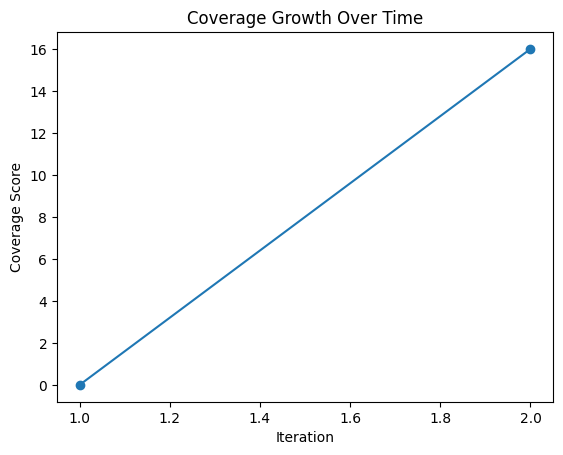

In [18]:
plot_coverage_growth(fuzzer.coverage_data)


#Income Tax Calculator

In [63]:
import random
import coverage
import tempfile
from collections import defaultdict
import importlib.util

In [65]:
module_path = "/content/tax_functions.py"
module_name = "tax_module"
spec = importlib.util.spec_from_file_location(module_name, module_path)
tax_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(tax_module)


oldtax = tax_module.oldtax
newtax = tax_module.newtax

In [86]:
class IncomeTaxFuzzer:
    def __init__(self, max_iterations=50):
        self.max_iterations = max_iterations
        self.coverage_tracker = coverage.Coverage(branch=True, data_file=tempfile.gettempdir() + "/.coverage")
        self.coverage_data = defaultdict(int)

        self.seed_population = [
            0, 249999, 250000, 250001, 500000, 750000, 999999, 1000000, 2500000,
            5000000, 10000000, -1, -100, -100000, 999999999
        ]


    def mutate_input(self, input_data):
        """ Mutate the taxable income """
        #mutation_type = random.choice(["increase", "decrease", "randomize", "zero", "negative"])
        mutation_type = random.choice(["increase", "decrease", "randomize"])

        mutated_input = input_data

        if mutation_type == "increase":
            mutated_input += random.randint(100, 100000)
        elif mutation_type == "decrease":
            mutated_input = max(0, mutated_input - random.randint(100, 100000))
        elif mutation_type == "randomize":
            mutated_input = random.randint(-500000, 10000000)
        elif mutation_type == "zero":
            mutated_input = 0
        elif mutation_type == "negative":
            mutated_input = -random.randint(1000, 500000)

        return mutated_input

    def run(self):
        """ Execute the fuzzing process """
        error_log_path = "fuzzer_errors.log"
        with open(error_log_path, "w") as f:
            f.write("Starting fuzzing tests...\n")

        for i in range(self.max_iterations):
            seed = random.choice(self.seed_population)
            mutated_input = self.mutate_input(seed)

            try:
                tax_old = oldtax(mutated_input)
                tax_new = newtax(mutated_input)

                # Check if the tax is within expected range
                if tax_old < 0 or tax_new < 0:
                    error_message = f"[ERROR] Negative tax found for income {mutated_input}\n"
                    print(error_message)
                    with open(error_log_path, "a") as f:
                        f.write(error_message)

                # Check if tax computation is consistent
                if mutated_input < 250000 and (tax_old > 0 or tax_new > 0):
                    error_message = f"[ERROR] Unexpected tax for non-taxable income: {mutated_input}\n"
                    print(error_message)
                    with open(error_log_path, "a") as f:
                        f.write(error_message)

                print(f"[Iteration {i+1}] Income: {mutated_input} | Old Tax: {tax_old} | New Tax: {tax_new}")

            except Exception as e:
                error_message = f"[EXCEPTION] Error at {mutated_input}: {e}\n"
                print(error_message)
                with open(error_log_path, "a") as f:
                    f.write(error_message)

        with open(error_log_path, "a") as f:
          f.write("Fuzzing completed. No errors detected.\n")

        print(f"Fuzzing complete. Errors (if any) logged to {error_log_path}")



In [87]:
if __name__ == "__main__":
    fuzzer = IncomeTaxFuzzer(max_iterations=50)
    fuzzer.run()

[Iteration 1] Income: 8688363 | Old Tax: 2515769.256 | New Tax: 2437769.256
[Iteration 2] Income: 7773697 | Old Tax: 2230393.464 | New Tax: 2152393.464
[Iteration 3] Income: 4554361 | Old Tax: 1225960.632 | New Tax: 1147960.632
[Iteration 4] Income: 7033549 | Old Tax: 1999467.288 | New Tax: 1921467.288
[Iteration 5] Income: 4426178 | Old Tax: 1185967.5359999998 | New Tax: 1107967.5359999998
[Iteration 6] Income: 1174447 | Old Tax: 171427.464 | New Tax: 114284.976
[Iteration 7] Income: 222603 | Old Tax: 0.0 | New Tax: 0.0
[Iteration 8] Income: 247518 | Old Tax: 0.0 | New Tax: 0.0
[Iteration 9] Income: 221498 | Old Tax: 0.0 | New Tax: 0.0
[Iteration 10] Income: 438542 | Old Tax: 9804.184000000001 | New Tax: 9804.184000000001
[Iteration 11] Income: 5044715 | Old Tax: 1378951.08 | New Tax: 1300951.08
[Iteration 12] Income: 655903 | Old Tax: 45427.824 | New Tax: 29213.912
[Iteration 13] Income: 0 | Old Tax: 0.0 | New Tax: 0.0
[Iteration 14] Income: 4942123 | Old Tax: 1346942.376 | New Tax: 

In [88]:
!ls -la /content/


total 84
drwxr-xr-x 1 root root  4096 Mar 14 03:02 .
drwxr-xr-x 1 root root  4096 Mar 14 02:00 ..
drwxr-xr-x 4 root root  4096 Mar 12 13:34 .config
-rw-r--r-- 1 root root 53248 Mar 14 02:03 .coverage
drwxr-xr-x 6 root root  4096 Mar 14 03:07 Income-Tax-Calculator
drwxr-xr-x 2 root root  4096 Mar 14 03:01 .ipynb_checkpoints
drwxr-xr-x 2 root root  4096 Mar 14 03:02 __pycache__
drwxr-xr-x 1 root root  4096 Mar 12 13:35 sample_data
-rw-r--r-- 1 root root  1689 Mar 14 03:01 tax_functions.py


In [89]:
!cat fuzzer_errors.log


Starting fuzzing tests...
Fuzzing completed. No errors detected.
